libraries

In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

ERROR:root:File `'import_modules.py'` not found.


NameError: name 'os' is not defined

load data

In [38]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()

# w2v 피쳐 사용

In [39]:
### Make corpus
p_level = 'gds_grp_mclas_nm'  # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
# unique 사용하지 않음.

def oversample(x, n=1, seed=0):   
    np.random.seed(seed)
    ids = x['cust_id'].unique().tolist() 
    Products = []
    
    for id_s in ids:    
        productList = x.query(f'cust_id == {id_s}')[p_level].tolist()
        for i in range(n):
            productList = list(np.append(productList, np.random.choice(productList, len(productList)*n, replace=True)))  # 복원추출 사용.
        Products.append(productList)
    return Products

X_train = oversample(df_train, 2)
X_test = oversample(df_test, 2)

### Training the Word2Vec model
num_features = 300 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 10 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(X_train, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        sg=1, # sg=1, workers=4 사용. sg=1 로 skip-gram방식 채택
                        seed=0, workers=4)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)

### Make features
# 구매상품에 해당하는 벡터의 최대/분산/표준편차 벡터를 feature로 만드는 전처리기(pipeline에서 사용 가능)
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.var([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ])  
    
# EmbeddingVectorizer 클래스를 통해서 피쳐뽑기

Vectorizer = EmbeddingVectorizer(w2v.wv)
Vectorizer.fit(X_train, y_train)

X_train_new = pd.DataFrame(Vectorizer.transform(X_train))
X_test_new = pd.DataFrame(Vectorizer.transform(X_test))

X_train_new

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.073496,0.080398,0.145611,0.184103,0.118218,-0.076940,0.108271,0.150486,0.098653,0.039330,...,1.609410e-03,0.000741,7.384875e-04,9.031271e-04,2.025226e-03,8.951852e-04,4.140919e-03,3.880606e-03,0.003128,2.638831e-03
1,0.032553,-0.046923,-0.078251,0.184103,-0.057609,-0.172039,0.108271,0.046501,0.017233,0.000135,...,1.054768e-03,0.000251,4.616053e-04,7.159606e-06,1.004440e-03,3.840471e-03,1.451831e-02,6.801920e-06,0.001076,1.172053e-04
2,0.018284,0.014411,-0.022105,0.105828,0.064546,-0.150204,0.011277,-0.016192,0.025675,-0.050630,...,8.013411e-04,0.000020,1.095528e-03,1.007207e-03,8.470262e-05,1.144583e-04,8.001179e-03,2.660352e-03,0.001132,3.510363e-03
3,0.072960,0.124736,0.053135,0.133276,0.094700,-0.110043,0.066018,0.092092,0.098653,0.013765,...,1.223840e-03,0.000431,9.306940e-04,8.279094e-04,1.175782e-03,7.388128e-04,1.081549e-03,2.387507e-03,0.001668,1.693971e-03
4,0.058989,0.083353,-0.068909,0.105828,0.118218,0.015907,-0.018048,-0.005897,0.013253,-0.078616,...,4.628412e-04,0.000031,1.449564e-03,1.185361e-04,2.760653e-03,3.067908e-04,4.154734e-04,8.527187e-04,0.001265,1.356983e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.043011,0.014411,-0.106379,0.159815,0.064546,-0.192030,0.098534,0.093272,0.011967,0.000774,...,2.536480e-03,0.000037,8.330590e-06,7.101690e-04,9.549269e-04,2.439103e-04,3.613085e-03,2.423560e-03,0.005205,1.297255e-03
3496,0.043011,0.014411,0.145611,0.159815,0.074662,-0.096624,0.098534,0.093272,0.024836,0.000774,...,9.469885e-04,0.001458,1.031651e-04,4.410559e-04,1.579662e-03,2.293277e-04,1.222218e-03,4.595431e-03,0.002772,2.975148e-03
3497,0.050376,-0.021996,0.005414,0.042394,0.042832,-0.196060,-0.058692,0.092115,-0.049482,-0.032716,...,0.000000e+00,0.000000,2.168404e-19,0.000000e+00,0.000000e+00,0.000000e+00,2.220446e-16,0.000000e+00,0.000000,0.000000e+00
3498,0.058989,-0.021903,-0.068909,0.081346,0.118218,-0.288637,-0.104703,-0.005897,0.013253,-0.109837,...,5.551115e-17,0.000000,0.000000e+00,1.249001e-16,3.469447e-18,5.551115e-17,0.000000e+00,2.220446e-16,0.000000,5.551115e-17


In [40]:
### Read data

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()


y_train.gender = y_train.gender.astype(str)

tr = pd.merge(df_train, y_train, on='cust_id')
tr2 = pd.concat([df_train, df_test])

corpus_goods = []
corpus_nm = []
corpus_mclas = []

for i in range(len(tr)):
    
    goods = tr.loc[i, 'goods_id']
    nm = tr.loc[i, 'gds_grp_nm']
    mclas = tr.loc[i, 'gds_grp_mclas_nm']
    gen = tr.loc[i, 'gender']
    
    corpus_goods.append([goods, gen])
    corpus_nm.append([nm, gen])
    corpus_mclas.append([mclas, gen])
    
tr['corpus_goods'] = corpus_goods
tr['corpus_nm'] = corpus_nm
tr['corpus_mclas'] = corpus_mclas

corpus_df = pd.DataFrame(tr.groupby('cust_id')['corpus_goods'].agg(lambda x: [j for i in x for j in i]))
corpus_df['corpus_nm'] = tr.groupby('cust_id')['corpus_nm'].agg(lambda x: [j for i in x for j in i])
corpus_df['corpus_mclas'] = tr.groupby('cust_id')['corpus_mclas'].agg(lambda x: [j for i in x for j in i])

display(corpus_df)

corpus1 = corpus_df['corpus_goods']
corpus2 = corpus_df['corpus_nm']
corpus3 = corpus_df['corpus_mclas']

def oversample2(data, n=1, seed=0):    
    
    np.random.seed(seed)
    
    customerProducts = []
    
    for cor in data:
            
        cor = list(np.append(cor, np.random.choice(cor, len(cor) * n, replace=True)))
        
        customerProducts.append(cor)
    
    return customerProducts

corpus1_sam = oversample2(corpus1, n=20, seed=0)
corpus2_sam = oversample2(corpus2, n=20, seed=0)
corpus3_sam = oversample2(corpus3, n=20, seed=0)

# W2V 학습

num_features = 20 # 문자 벡터 차원 수
min_word_count = 0 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기

wv_item1 = word2vec.Word2Vec(corpus1_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

wv_item2 = word2vec.Word2Vec(corpus2_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

wv_item3 = word2vec.Word2Vec(corpus3_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

## goods_id

def get_0_similarity_goods(product):
    try:
        sim = wv_item1.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_goods(product):
    try:
        sim = wv_item1.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_nm

def get_0_similarity_nm(product):
    try:
        sim = wv_item2.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_nm(product):
    try:
        sim = wv_item2.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_mclas_nm

def get_0_similarity_mclas(product):
    try:
        sim = wv_item3.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_mclas(product):
    try:
        sim = wv_item3.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim


tr2['goods_0_similarity'] = tr2['goods_id'].apply(get_0_similarity_goods)
tr2['goods_1_similarity'] = tr2['goods_id'].apply(get_1_similarity_goods)
tr2['nm_0_similarity'] = tr2['gds_grp_nm'].apply(get_0_similarity_nm)
tr2['nm_1_similarity'] = tr2['gds_grp_nm'].apply(get_1_similarity_nm)
tr2['mclas_0_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_0_similarity_mclas)
tr2['mclas_1_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_1_similarity_mclas)

train_test = pd.DataFrame({'cust_id' : range(5982)}).set_index('cust_id')

train_test['goods_0_similarity'] = tr2.groupby('cust_id')['goods_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['goods_1_similarity'] = tr2.groupby('cust_id')['goods_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_0_similarity'] = tr2.groupby('cust_id')['nm_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_1_similarity'] = tr2.groupby('cust_id')['nm_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_0_similarity'] = tr2.groupby('cust_id')['mclas_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_1_similarity'] = tr2.groupby('cust_id')['mclas_1_similarity'].apply(lambda x: np.nanmean(x))


X_train_w2v = train_test[:3500]
X_test_w2v = train_test[3500:]

idx = [i for i in range(3500,5982)]

X_test_new['cust_id'] = idx
X_test_new = X_test_new.set_index('cust_id')

X_train_new = pd.concat([X_train_w2v, X_train_new], axis=1)
X_test_new = pd.concat([X_test_w2v, X_test_new], axis=1)
X_test_new = X_test_new.fillna(X_test_new.mean())

,corpus_goods,corpus_nm,corpus_mclas
cust_id,,,
0,"[127105, 0, 342220, 0, 127105, 0, 342205, 0, 3...","[기초 화장품, 0, 니 트, 0, 기초 화장품, 0, 니 트, 0, 상품군미지...","[화장품, 0, 시티웨어, 0, 화장품, 0, 시티웨어, 0, 기타, 0, 화장품,..."
1,"[550231, 0, 550231, 0, 462102, 0]","[아웃도아, 0, 아웃도아, 0, 트래디셔널Ⅰ, 0]","[스포츠, 0, 스포츠, 0, 트래디셔널, 0]"
2,"[461119, 1, 461119, 1, 461119, 1, 461119, 1]","[시티캐주얼, 1, 상품군미지정, 1, 상품군미지정, 1, 시티캐주얼, 1]","[남성 캐주얼, 1, 기타, 1, 기타, 1, 남성 캐주얼, 1]"
3,"[35145, 1, 821104, 1, 32263, 1, 50114, 1, 5010...","[회, 1, 한실침구, 1, 생선, 1, 일반가공식품, 1, 일반가공식품, 1, 일...","[수산품, 1, 침구/수예, 1, 수산품, 1, 가공식품, 1, 가공식품, 1, 가..."
4,"[127109, 0, 150124, 0, 150124, 0]","[기초 화장품, 0, 상품군미지정, 0, 보석, 0]","[화장품, 0, 기타, 0, 보석, 0]"
...,...,...,...
3495,"[143102, 1, 143102, 1]","[L/C골프의류, 1, 상품군미지정, 1]","[골프, 1, 기타, 1]"
3496,"[405107, 1, 173197, 1, 381116, 1, 996101, 1, 3...","[N.B정장, 1, 캐릭터 여화, 1, 시니어, 1, 상품군미지정, 1, 인텔리젼스...","[남성정장, 1, 구두, 1, 시티웨어, 1, 기타, 1, 시티웨어, 1, 시티웨어..."
3497,"[647178, 0]","[국산주방, 0]","[주방용품, 0]"


## 중분류구매건수

In [41]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

,cust_id,0,1,2,3,4,5,6,7,8,...,100,101,102,103,104,105,106,107,108,109
0,0,0.625380,0.034396,-0.672246,0.441779,0.159294,-0.598718,0.325886,-0.936302,0.305429,...,-0.143142,0.118564,-0.002334,0.089901,-0.111054,-0.021497,0.140365,0.117912,-0.126485,0.046712
1,1,-1.107635,-0.008147,-0.036582,-0.227227,-0.173067,0.257546,0.036107,-0.059078,-0.073846,...,0.030561,-0.018014,0.032755,0.015114,0.011464,-0.002095,-0.073120,-0.051948,0.005610,-0.007939
2,2,-1.099033,-0.109059,-0.020829,0.007957,-0.059710,0.090729,0.179059,-0.068382,0.062943,...,0.002262,0.035945,-0.017813,-0.008323,-0.036238,0.021623,0.038809,0.046284,0.007039,0.014445
3,3,0.265591,-0.619277,-0.279149,-0.187955,0.023135,-0.135279,-0.067050,0.675716,-0.159730,...,0.131376,0.064030,-0.118500,0.066814,-0.149491,-0.003301,0.486243,-0.482798,-0.028555,-0.156546
4,4,-1.141518,-0.191579,0.005533,-0.059629,0.026487,0.013643,-0.095080,0.043151,-0.057431,...,0.008822,0.004029,0.004533,-0.000862,-0.005974,-0.006765,0.007707,0.013415,-0.002152,0.008844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.877498,0.236507,-0.127787,-0.066931,-0.135133,0.047662,0.136196,-0.051518,-0.006189,...,0.100014,-0.477439,-0.028659,0.204758,-0.015639,0.083038,0.010453,-0.005576,-0.006840,0.081172
5978,5978,-1.162111,-0.159106,0.019576,0.078777,0.026611,-0.007421,-0.020261,0.025530,-0.021468,...,0.005455,0.005500,0.013200,0.006884,0.011396,0.006313,-0.050464,-0.032066,-0.036101,-0.007855
5979,5979,0.199450,1.781264,-0.540263,0.071173,0.331206,1.250888,0.351207,-0.141133,-0.117322,...,0.100453,0.028486,-0.128008,0.088439,-0.112445,-0.079405,0.109667,0.038992,-0.088774,0.054421
5980,5980,-0.635700,-0.227858,-0.237216,0.009492,-0.166560,-0.074526,0.129139,-0.274902,-0.380003,...,-0.285796,0.651523,0.113559,-0.241631,0.065565,0.000818,-0.040256,-0.085648,-0.044685,-0.053650


In [42]:
X_train_new = pd.concat([X_train_new, X_train],axis=1)
X_test_new = pd.concat([X_test_new, X_test],axis=1)

In [45]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)

models = [logreg]

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [10:06<00:00,  6.39s/it]
No handles with labels found to put in legend.


LogisticRegression (78, 0.7714157676163755)


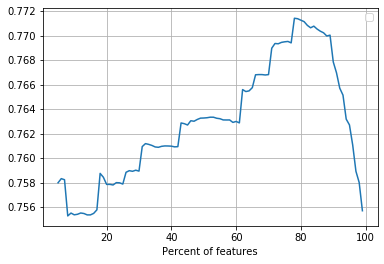

In [46]:
skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기 <- 처음에만 100프로 찍고 이후 조절하기
    for percentile in tqdm(range(5,100)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train_new,y_train)
       
        # cross_val_score 4번의 평균값 (정수시 skf로 자동으로 들어간다)
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skf).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

In [47]:
select_p = SelectPercentile(percentile=best_score[0]).fit(X_train_new, y_train)
X_train = select_p.transform(X_train_new)
X_test = select_p.transform(X_test_new)

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [49]:
X_train

array([[ 0.42397413, -0.15942734,  0.22722355, ..., -0.04203614,
         0.06427523, -0.04658385],
       [ 0.05566147, -0.07896031,  0.22001393, ..., -0.065726  ,
         0.00869267, -0.03072586],
       [ 0.25096082, -0.10907461,  0.3356292 , ..., -0.05385177,
         0.04346948,  0.04617864],
       ...,
       [ 0.20217836,  0.15140989,  0.1548111 , ...,  0.46998929,
         0.48714698,  0.12402009],
       [-0.00124732,  0.18416587,  0.04563777, ..., -0.04194736,
         0.12063884,  0.00730761],
       [ 0.09707959,  0.05212122,  0.08170985, ..., -0.01987726,
        -0.0553228 , -0.06801691]])

In [50]:
X_test

array([[-0.14112662,  0.12312739, -0.02454633, ..., -0.60924107,
        -0.15089218,  0.04983113],
       [ 0.21720986,  0.04588034,  0.15102925, ..., -0.07499923,
         0.1774724 , -0.40321557],
       [ 0.30470785,  0.19947326,  0.17089182, ..., -0.33812536,
         0.32130468,  0.30533392],
       ...,
       [-0.08812496,  0.09577508, -0.02157958, ...,  0.26643398,
         0.20451318, -0.00376175],
       [ 0.18798492,  0.13426903,  0.13007931, ..., -0.1126637 ,
         0.09620208, -0.14311272],
       [ 0.26636136,  0.26530828,  0.10542049, ..., -0.00613151,
         0.11390934, -0.17718841]])

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

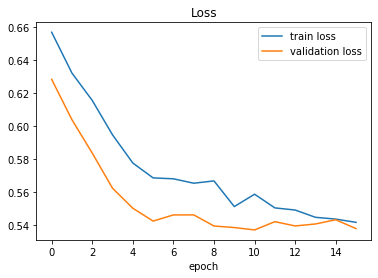

 20%|████████████████▊                                                                   | 1/5 [00:01<00:06,  1.57s/it]

0.787665805340224


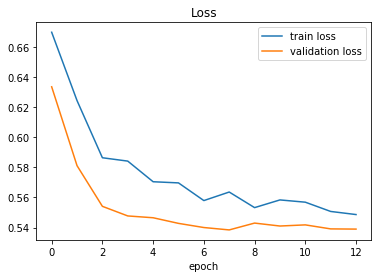

 40%|█████████████████████████████████▌                                                  | 2/5 [00:02<00:04,  1.51s/it]

0.788182601205857


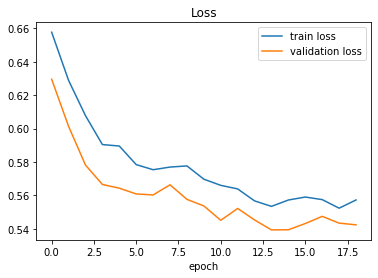

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:04<00:03,  1.56s/it]

0.7862704565030145


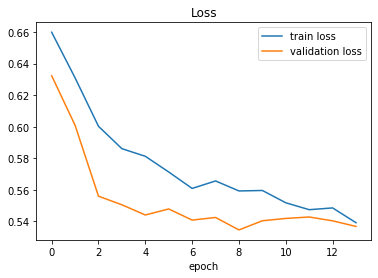

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:06<00:01,  1.52s/it]

0.7887683031869078


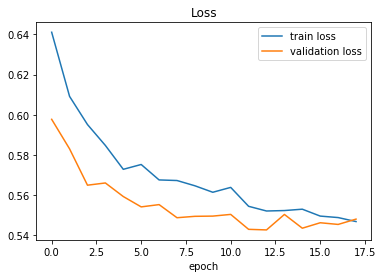

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]

0.7806244616709733


In [51]:
for i in tqdm(range(5)):       
    # model architecture
    model = Sequential(name = 'dnn model')
    model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # choose the optimizer and the cost function
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    # model.summary()


    # train the model -> verbose=0: silent
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
        batch_size=64, epochs=200, callbacks=callbacks, verbose=0)

    # visualize training history
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.show()


    # plt.plot(hist.history['acc'], label='train acc')
    # plt.plot(hist.history['val_acc'], label='validation acc')
    # plt.legend()
    # plt.xlabel('epoch')
    # plt.title('acc')
    # plt.show()

    # evaluate the model performance

    #print(model.evaluate(X_test, y_test))
    #if roc_auc_score(y_test, model.predict(X_test)) >= 0.755:
    #    print(f'1층: {dr1},드롭1: {drop1},2층: {dr2}, 드롭2: {drop2}, 3층: {dr3}')
    #    print(roc_auc_score(y_test, model.predict(X_test)))
    print(roc_auc_score(y_valid, model.predict(X_valid)))

In [52]:
pred = model.predict(X_test).flatten()
print(pred.shape)


(2482,)


In [53]:
ID_dep = [i for i in range(3500,5982)]

In [54]:
# make submissions

# pd.DataFrame({'cust_id': ID_dep, 'gender': pred}).to_csv('submission_w2v대 dnn.csv', index=False, encoding='cp949')
# pd.read_csv('submission_w2v대 dnn.csv', encoding='cp949')

## +ref_dnn modeling

In [55]:
# 모형 학습 시 RMSE를 계산하는 함수
import keras.backend as K
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [56]:
# 예측값을 저장할 폴더 생성
folder = 'Ensemble'
if not os.path.isdir(folder):
    os.mkdir(folder)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

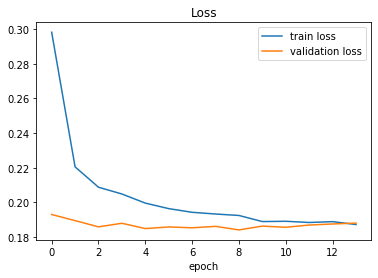

 20%|████████████████▊                                                                   | 1/5 [00:02<00:11,  2.85s/it]

0.7801291989664083 SEED: 5390


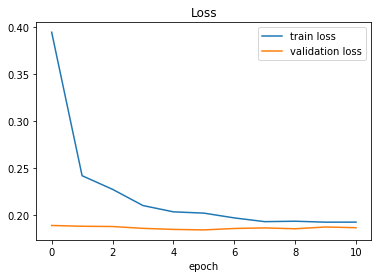

 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:07,  2.56s/it]

0.784074074074074 SEED: 603


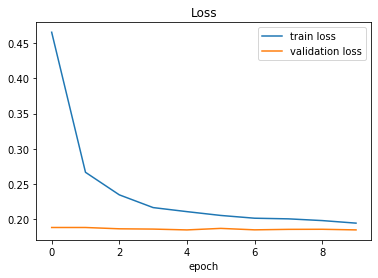

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:06<00:04,  2.33s/it]

0.7883204134366925 SEED: 4241


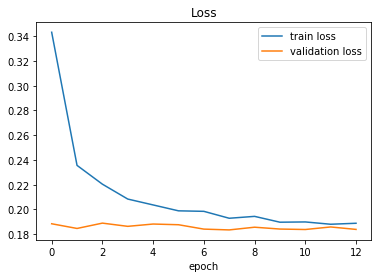

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:16<00:04,  4.60s/it]

0.786520241171404 SEED: 9286


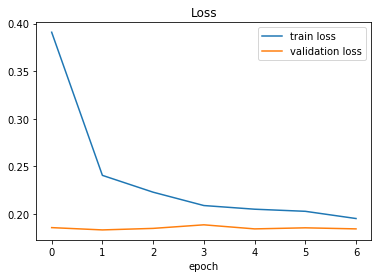

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.60s/it]

0.7870628768303186 SEED: 7304


In [58]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='elu')(x)
    model = Model(input, output)  

    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])

    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                    callbacks=callbacks, shuffle=False, verbose=0)
    
     # visualize training history
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.show()

    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)


    # Make submissions
#     submission = pd.DataFrame({
#         "item_id": IDtest, 
#         "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
#     })
#     t = pd.Timestamp.now()
#     fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)    
 

In [20]:
# nf = 0
# for f in os.listdir(folder):
#     ext = os.path.splitext(f)[-1]
#     if ext == '.csv': 
#         s = pd.read_csv(folder+"/"+f)
#     else: 
#         continue
#     if len(s.columns) !=2:
#         continue
#     if nf == 0: 
#         slist = s
#     else: 
#         slist = pd.merge(slist, s, on="item_id")
#     nf += 1

# p = 4.5 # 이 값에 따라 성능이 달라짐 (p=1: 산술평균, p>1: 멱평균)    
# if nf >= 2:
#     pred = 0
#     for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
#     pred = pred / nf    
#     pred = pred**(1/p)

#     submission = pd.DataFrame({'cust_id': slist.item_id, 'gender': pred})
#     t = pd.Timestamp.now()
#     fname = f"p{p}mean_dnn_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)

In [19]:
# nf = 0
# for f in os.listdir(folder):
#     ext = os.path.splitext(f)[-1]
#     if ext == '.csv': 
#         s = pd.read_csv(folder+"/"+f)
#     else: 
#         continue
#     if len(s.columns) !=2:
#         continue
#     if nf == 0: 
#         slist = s
#     else: 
#         slist = pd.merge(slist, s, on="item_id")
#     nf += 1

# p = 3.5 # 이 값에 따라 성능이 달라짐 (p=1: 산술평균, p>1: 멱평균)    
# if nf >= 2:
#     pred = 0
#     for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
#     pred = pred / nf    
#     pred = pred**(1/p)

#     submission = pd.DataFrame({'cust_id': slist.item_id, 'gender': pred})
#     t = pd.Timestamp.now()
#     fname = f"p{p}mean_dnn_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)